## Imports

In [1]:
import os
import sys
import scipy
import datetime

In [2]:
sys.path.append(os.path.join(os.pardir, 'src'))

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
from tqdm.notebook import tqdm
from collections import defaultdict

In [6]:
from CBO.distributions import Normal
from CBO.functions import rastrigin, rastrigin_c, square
from CBO.minimize import minimize
from CBO.visualizations import visualize_trajectory_convergence
from CBO.train import train, NeuralNetworkObjectiveFunction, TensorboardLogging, compute_model_dimensionality

## Data preparation

In [7]:
def load_mnist_data():
    (X_train, y_train),(X_test, y_test) = mnist.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = load_mnist_data()

## Model training

In [9]:
def build_default_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
    ])

In [10]:
def build_small_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.BatchNormalization(center=False, scale=False),
      tf.keras.layers.Dense(10),
    ])

In [11]:
class MeanCrossEntropy():
    def __init__(self):
        self._loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                                   reduction=tf.keras.losses.Reduction.NONE)
        
    def __call__(self, y_true, y_pred):
        loss_value = self._loss(y_true, y_pred)
        return tf.reduce_mean(loss_value) / 10

In [12]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [13]:
! rm -rf logs/fit

In [14]:
tensorboard_logging = TensorboardLogging('cbo_small', 'logs/fit')

In [ ]:
model = build_small_model()

In [16]:
cbo_small_model, trajectory = train(build_small_model(), loss, X_train, y_train, n_particles=100, 
                                    time_horizon=11,
                                    optimizer_config = {'alpha': 50, 'sigma': 0.4**0.5, 'dt': 0.1}, 
                                    initial_distribution=Normal(0, 1),
                                    return_trajectory=True, verbose=True, particles_batches=10, 
                                    dataset_batches=1000, X_val=X_test, y_val=y_test, 
                                    tensorboard_logging=tensorboard_logging, cooling=True,
                                    update_all_particles=False)

[<tf.Variable 'dense_2/kernel:0' shape=(784, 10) dtype=float32, numpy=
array([[-0.14516944,  0.00786357,  0.47175708, ..., -0.19091775,
         0.382456  , -0.08107416],
       [-0.06868359, -0.04624714, -0.19722103, ..., -0.05049304,
         0.06357617, -0.32025295],
       [ 0.23384903, -0.08974513,  0.02408716, ...,  0.09842881,
        -0.1060183 , -0.2066702 ],
       ...,
       [-0.00469659, -0.18124534,  0.12973998, ...,  0.11552718,
         0.19999361,  0.15779951],
       [-0.04212341,  0.17515905,  0.02509295, ..., -0.16755655,
         0.05559932,  0.12630181],
       [-0.11071892, -0.09863067, -0.21750388, ..., -0.08513658,
         0.05618405, -0.0087222 ]], dtype=float32)>, <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32, numpy=
array([-0.10635534,  0.02642738, -0.01176846, -0.22256412, -0.05227656,
       -0.04919318, -0.04409999,  0.02252233, -0.26873353, -0.21505052],
      dtype=float32)>, <tf.Variable 'dense_3/kernel:0' shape=(10, 10) dtype=float32, numpy

[<tf.Variable 'dense_2/kernel:0' shape=(784, 10) dtype=float32, numpy=al accuracy: 0.136
array([[ 0.04277581, -0.04467337,  0.10063037, ..., -0.12597746,
         0.24746756, -0.1670665 ],
       [-0.04740131,  0.01179607, -0.19508652, ...,  0.05960533,
         0.0007293 , -0.05741625],
       [ 0.01641452, -0.15391658,  0.11583042, ...,  0.13676156,
         0.10694358, -0.22398242],
       ...,
       [ 0.04677492, -0.08939095, -0.05304649, ...,  0.13025445,
         0.3327111 ,  0.07113364],
       [ 0.04650617,  0.15908423, -0.0828274 , ..., -0.04629928,
         0.11441872, -0.03070166],
       [-0.00382246, -0.31052268, -0.10379913, ..., -0.06325631,
        -0.01623119,  0.07756887]], dtype=float32)>, <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32, numpy=
array([-0.15773992,  0.06138195,  0.02676682, -0.22554298,  0.06026046,
       -0.02611328,  0.11136876, -0.1633957 , -0.06903205,  0.00280906],
      dtype=float32)>, <tf.Variable 'dense_3/kernel:0' shape=(10, 10) dt

KeyboardInterrupt: 

In [16]:
cbo_small_model, trajectory = train(build_small_model(), loss, X_train, y_train, n_particles=100, 
                                    time_horizon=2,
                                    optimizer_config = {'alpha': 50, 'sigma': 0.4**0.5, 'dt': 0.1}, 
                                    initial_distribution=Normal(0, 1),
                                    return_trajectory=True, verbose=True, particles_batches=10, 
                                    dataset_batches=1000, X_val=X_test, y_val=y_test, 
                                    tensorboard_logging=tensorboard_logging, cooling=True)

KeyboardInterrupt: 

In [33]:
def conduct_tf_training(model, X_train, X_test, y_train, y_test, with_tensorboard=False,
                        model_description='', epoches=10):
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    if with_tensorboard:
        log_dir = 'logs/fit/' + model_description
        if model_description is '':
            log_dir += datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        model.fit(x=X_train, y=y_train, epochs=epoches, validation_data=(X_test, y_test),
                  callbacks=[tensorboard_callback])
    else:
        model.fit(x=X_train, y=y_train, epochs=epoches, validation_data=(X_test, y_test))
    
    return model

In [34]:
adam_small_model = conduct_tf_training(build_small_model(),
                                       X_train, X_test, y_train, y_test,
                                       with_tensorboard=True,
                                       model_description='adam_small', epoches=20)

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6268 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.3458 - val_sparse_categorical_accuracy: 0.9083
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3603 - sparse_categorical_accuracy: 0.9010 - val_loss: 0.3123 - val_sparse_categorical_accuracy: 0.9088
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3197 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.2851 - val_sparse_categorical_accuracy: 0.9169
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3029 - sparse_categorical_accuracy: 0.9137 - val_loss: 0.2605 - val_sparse_categorical_accuracy: 0.9240
Epoch 5/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2919 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.2741 - val_sparse_categorical_accuracy: 0.9210
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2862 - spars

## Results analysis

In [17]:
def calculate_cbo_weights(particles, objective, alpha=50):
    objective_values = np.array([objective(particle) for particle in particles])
    weights = np.exp(-alpha * (objective_values - objective_values.min())).reshape(-1, 1)
    return weights / weights.sum()

In [18]:
nn_loss = NeuralNetworkObjectiveFunction(build_small_model(), loss, X_train, y_train)

In [19]:
def update_model_parameters(model, parameters):
    current_position = 0
    for weight in model.trainable_weights:
        next_position = current_position + tf.size(weight)
        weight.assign(tf.reshape(parameters[current_position:next_position], weight.shape))
        current_position = next_position
    return model

In [24]:
small_model_dim = tf.reduce_sum([len(tf.reshape(weight, -1).numpy()) 
                                 for weight in build_small_model().trainable_weights])

In [36]:
adam_small_model_weights = tf.concat([tf.reshape(weight, -1) 
                                      for weight in adam_small_model.trainable_weights], 0)

In [42]:
model = build_small_model()

for i in range(10):
    weights = adam_small_model_weights + Normal(0, 0.1).sample(small_model_dim)
    model = update_model_parameters(model, weights)
    acc = tf.keras.metrics.SparseCategoricalAccuracy()
    acc.update_state(y_train, model.predict(X_train))
    print(f'Model {i} train accuracy: {acc.result().numpy()}')

Model 0 train accuracy: 0.513700008392334
Model 1 train accuracy: 0.5256500244140625
Model 2 train accuracy: 0.502916693687439
Model 3 train accuracy: 0.5103333592414856
Model 4 train accuracy: 0.47823333740234375
Model 5 train accuracy: 0.3970166742801666
Model 6 train accuracy: 0.5589166879653931
Model 7 train accuracy: 0.4458000063896179
Model 8 train accuracy: 0.5024833083152771
Model 9 train accuracy: 0.48056668043136597


In [27]:
def plot_particle_loss(trajectory, particle_ind, nn_loss):
    timestamps = list(sorted(trajectory.keys()))
    losses = []
    for ts in timestamps:
        losses.append(nn_loss(trajectory[ts]['particles'][particle_ind]))
    plt.clf()
    plt.plot(timestamps, losses)
    plt.show()

In [28]:
plot_particle_loss(trajectory, 1, nn_loss)

NameError: name 'trajectory' is not defined

In [22]:
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [45]:
weights = calculate_cbo_weights(trajectory[0]['particles'], nn_loss)

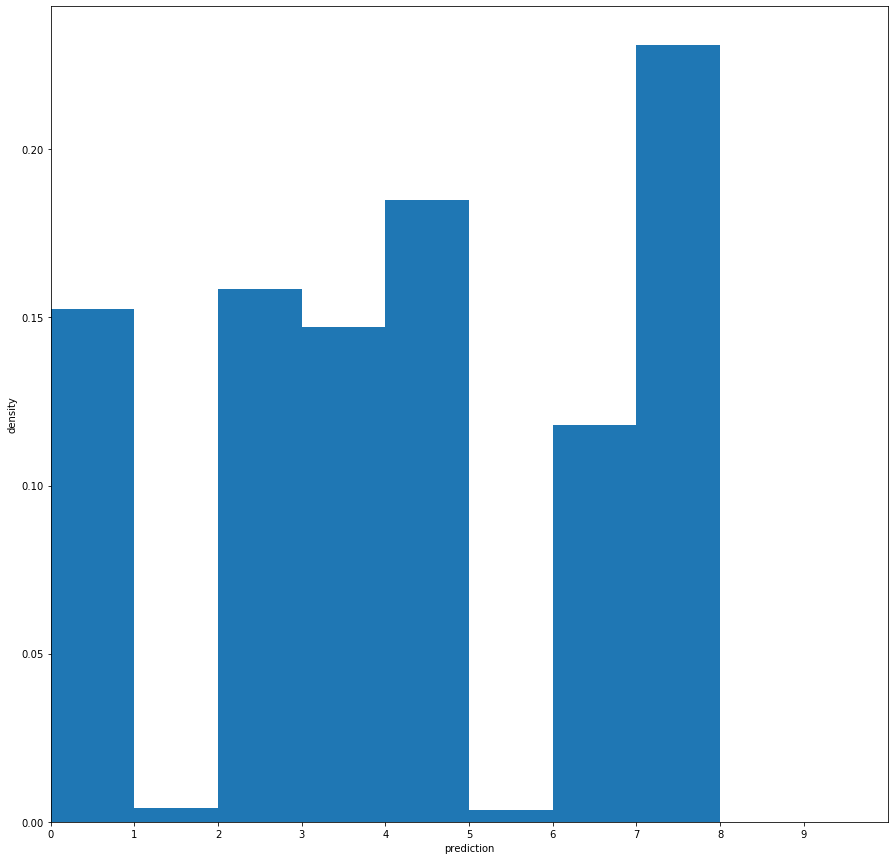

Train accuracy: 0.10432222485542297


In [46]:
best_particle_ind = np.equal(weights.max(), weights).nonzero()[0][0]
best_particle = trajectory[0]['particles'][best_particle_ind]
best_model = update_model_parameters(build_small_model(), trajectory[0]['particles'][best_particle_ind])
plot_model_predictive_distribution(build_small_model(), trajectory[0]['particles'][best_particle_ind], X_train)
accuracy.update_state(y_train, best_model.predict(X_train))
print(f'Train accuracy: {accuracy.result().numpy()}')

In [53]:
tf.norm(trajectory[0.1]['particles'] - trajectory[0]['particles'], ord=2, axis=1)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([30.012262, 28.13963 , 28.76306 , 29.332449, 27.918653, 29.64847 ,
       29.253466, 29.82872 , 28.382309, 29.476631, 29.000154, 28.63902 ,
       29.209688, 29.747719, 28.91417 , 29.165155, 28.928873, 29.082876,
       28.821875, 28.798397, 28.760605, 29.940268, 29.61061 , 29.368599,
       28.976767, 29.010292, 29.689219, 29.220585, 28.856924, 28.920061,
       28.712893, 29.627972, 29.223648, 29.182852, 30.082535, 28.94981 ,
       28.656834, 29.384651, 28.123726, 28.978224, 29.431694, 28.576618,
       30.359015, 28.791925, 28.93443 , 28.836164, 28.065409, 29.942053,
       29.056396, 29.495033, 28.02128 , 30.950632, 29.315552, 28.770918,
       29.329752, 28.71105 , 27.870972, 29.882399, 31.111378, 29.318338,
       28.54138 , 29.424932, 27.593449, 28.751928, 28.055006, 28.539793,
       28.165737, 28.900852, 29.111261, 28.508198, 29.38199 , 28.854279,
       28.404985, 28.555517, 29.615587, 30.120384, 28.848822, 28.971704,
   

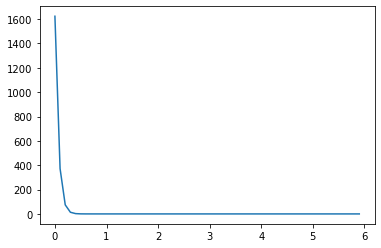

In [29]:
plt.clf()
timestamps = list(sorted(trajectory.keys()))
distances = [tf.reduce_sum((best_particle - trajectory[ts]['particles'][best_particle_ind]) ** 2)
             for ts in timestamps]
plt.plot(timestamps, distances)

In [30]:
consensus_postions = [trajectory[ts]['consensus'] for ts in sorted(trajectory.keys())]

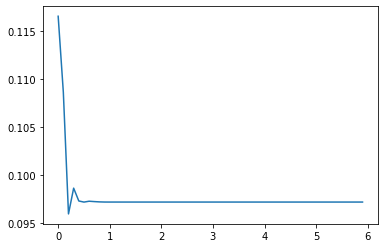

In [31]:
plt.clf()
plt.plot(timestamps, [consensus_postions[i][0][1] for i in range(len(consensus_postions))])
plt.show()

In [32]:
all_weights = np.concatenate([tf.reshape(w, -1).numpy() for w in adam_small_model.trainable_weights])

NameError: name 'adam_small_model' is not defined

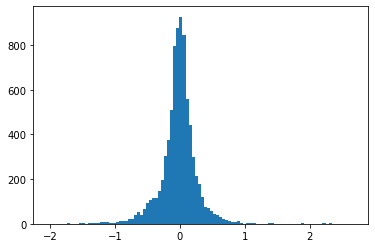

In [20]:
plt.clf()
plt.hist(all_weights, bins=100)
plt.show()

In [27]:
def get_model_predictions(model, parameters, X):
    model = update_model_parameters(model, tf.reshape(parameters, -1))
    predictions = model(X).numpy()
    return np.argmax(predictions, axis=1)

def get_predictions_distribution(values):
    _, counts = np.unique(values, return_counts=True)
    return 1. * counts / counts.sum()

def plot_model_predictive_distribution(model, parameters, X, title=''):
    plt.clf()
    plt.xticks(range(10))
    plt.xlim((0, 10))
    plt.title(title)
    predictions, counts = np.unique(get_model_predictions(model, parameters, X),
                                    return_counts=True)
    plt.bar(x=predictions + 0.5, height=1.*counts/counts.sum(), width=1)
    plt.xlabel('prediction')
    plt.ylabel('density')
    plt.show()

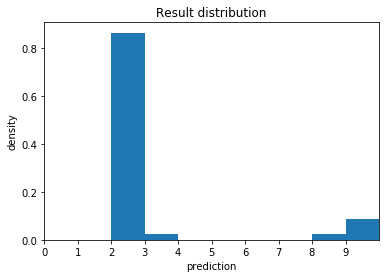

In [41]:
last_timestamp = list(sorted(trajectory.keys()))[-1]
plot_model_predictive_distribution(build_small_model(),
                                   trajectory[last_timestamp]['consensus'],
                                   X_test, 'Result distribution')

In [38]:
plt.rcParams['figure.figsize'] = (10, 10)

In [39]:
def plot_particles_entropy(model, trajectoty, X, n_particles=10, logarithmic=False):
    overall_particles = len(trajectory[0]['particles'])
    particles = list(sorted(np.random.choice(overall_particles, n_particles, replace=False)))
    entropy = defaultdict(lambda: [])
    timestamps = list(sorted(trajectoty.keys()))
    for timestamp in tqdm(timestamps):
        for particle in particles:
            predictions = get_model_predictions(model, trajectoty[timestamp]['particles'][particle], X)
            entropy[particle].append(scipy.stats.entropy(get_predictions_distribution(predictions)))
    plt.clf()
    plt.rcParams['figure.figsize'] = (15, 15)
    for particle, particle_entropy in entropy.items():
        plt.plot(timestamps, np.log(particle_entropy) if logarithmic else particle_entropy, 
                 label=f'particle {particle}')
    plt.xlabel('Timestamp')
    plt.ylabel('Predictive distribution entropy')
    plt.legend()
    plt.show()

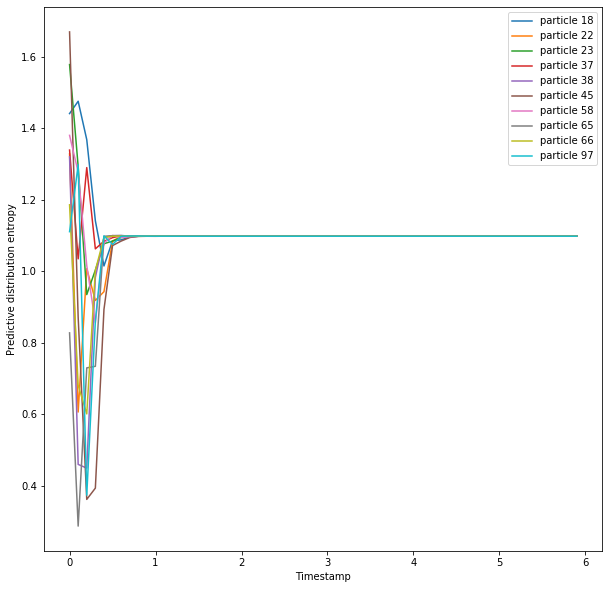

In [40]:
plot_particles_entropy(build_small_model(), trajectory, X_train)

In [37]:
def visualize_particle_path_1d(trajectory, particle_ind, projection_dimenssion):
    timestamps = list(sorted(list(trajectory.keys())))
    particle_positions = [trajectory[ts]['particles'][particle_ind][projection_dimenssion]
                          for ts in timestamps]
    plt.clf()
    plt.plot(timestamps, particle_positions)
    plt.xlabel('Timestamp')
    plt.ylabel('Particle position')
    plt.show()
    
def visalize_particles_shift(trajectory):
    timestamps = list(sorted(list(trajectory.keys())))
    shifts = []
    for ind, ts in enumerate(timestamps[:-1]):
        shifts.append(tf.norm(trajectory[ts]['particles'] - trajectory[timestamps[ind + 1]]['particles'],
                              ord='euclidean'))
    plt.clf()
    plt.plot(timestamps[1:], shifts)
    plt.xlabel('Timestamp')
    plt.ylabel('Shift')
    plt.show()
    
def visalize_particles_std(trajectory, logarithmic=False):
    timestamps = list(sorted(list(trajectory.keys())))
    stds = []
    for ts in timestamps:
        stds.append(tf.math.reduce_std(trajectory[ts]['particles']))
    if logarithmic:
        stds = np.log(stds)
    plt.clf()
    plt.plot(timestamps, stds)
    plt.xlabel('Timestamp')
    plt.ylabel('Std')
    plt.show()

# contrains accuracies from different batches!
def visualize_cbo_accuracy(trajectory):
    timestamps = list(sorted(list(trajectory.keys())))
    accuracies = [trajectory[ts]['accuracy'] for ts in timestamps]
    plt.clf()
    plt.plot(timestamps, accuracies)
    plt.xlabel('Timestamp')
    plt.ylabel('Accuracy')
    plt.show()

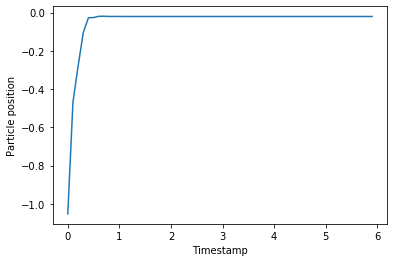

In [61]:
visualize_particle_path_1d(trajectory, best_particle_ind, 4)

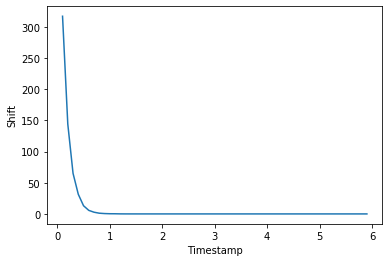

In [32]:
visalize_particles_shift(trajectory)

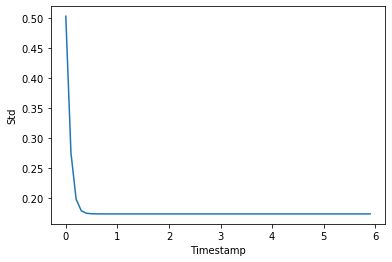

In [20]:
visalize_particles_std(trajectory)

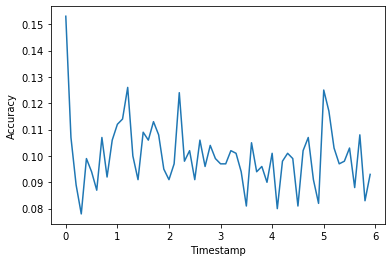

In [21]:
visualize_cbo_accuracy(trajectory)

## Random initialization leads to unbalanced predictions of the initial model!

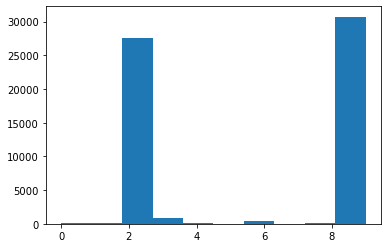

In [51]:
model = build_small_model()
initial_weights = tf.Variable(Normal(0, 1).sample(compute_model_dimensionality(model)))
model = update_model_parameters(model, initial_weights)
y_pred = np.argmax(tf.nn.softmax(model(X_train)), axis=1)
plt.hist(y_pred)
plt.show()